<a href="https://colab.research.google.com/github/weco1014/ML/blob/main/signate-1/Bank_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 18.8 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0fbc6f0ec31b5f67d37037ede3de38c79ffbad4ebb91c3f145f3bb68b9669fe2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Download 100%.


In [ ]:
#コンペのファイル一覧表示
! signate files --competition-id=133

#コンペのファイルダウンロード
! signate download --competition-id=133

#zip解凍
! unzip train_images.zip
! unzip test_images.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: test_images/test_3699.jpg  
  inflating: test_images/test_37.jpg  
  inflating: test_images/test_370.jpg  
  inflating: test_images/test_3700.jpg  
  inflating: test_images/test_3701.jpg  
  inflating: test_images/test_3702.jpg  
  inflating: test_images/test_3703.jpg  
  inflating: test_images/test_3704.jpg  
  inflating: test_images/test_3705.jpg  
  inflating: test_images/test_3706.jpg  
  inflating: test_images/test_3707.jpg  
  inflating: test_images/test_3708.jpg  
  inflating: test_images/test_3709.jpg  
  inflating: test_images/test_371.jpg  
  inflating: test_images/test_3710.jpg  
  inflating: test_images/test_3711.jpg  
  inflating: test_images/test_3712.jpg  
  inflating: test_images/test_3713.jpg  
  inflating: test_images/test_3714.jpg  
  inflating: test_images/test_3715.jpg  
  inflating: test_images/test_3716.jpg  
  inflating: test_images/test_3717.jpg  
  inflating: test_images/test_3718.jpg  
  inflating: test_images/test

In [ ]:
#colab内のファイル一覧表示
%ls

label_master.tsv  sample_submit.tsv  test_images.zip  train_images.zip
sample_data/      test_images/       train_images/    train_master.tsv


In [ ]:
#ライブラリなどのインポート
import tensorflow as tf
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import shutil
#shutil.rmtree('train_images_gen')

In [ ]:
# 1枚あたり5枚の画像を水増し
N_img = 3

# 入力画像の保存先パス
input_path = 'train_images/'
files = glob.glob(input_path + '/*.jpg')
 
# 出力画像の保存先パス
output_path = "train_images_gen/"
if os.path.isdir(output_path) == False:
    os.mkdir(output_path)

train_images = np.empty((N_img*5000,96,96,3))
train_labels = np.empty(N_img*5000) 
count_train = -1

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator


def generate(file,count_train,label):
    img = load_img(file)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
 
    # ImageDataGeneratorの生成
    datagen = ImageDataGenerator(
    rotation_range=30., # ランダムに回転させる範囲
    width_shift_range=0.05, # ランダムに幅をシフトさせる範囲
    height_shift_range=0.05, # ランダムに高さをシフトさせる範囲
    brightness_range=[0.2, 1.0], # ランダムに明るさを変化させる範囲
    channel_shift_range=150., #ランダムに色を変更する範囲
    zoom_range=0.03,        # ランダムにズームさせる範囲
    horizontal_flip=True, # ランダムに水平方向に反転させる
    vertical_flip=False, # ランダムに垂直方向に反転させる
    )
 
    # 1枚あたり5枚の画像を水増し生成
    dg = datagen.flow(x, batch_size=1, save_to_dir=output_path, save_prefix='img', save_format='jpg')
    for i in range(N_img):
        train_images[N_img*count_train+i] = np.array((dg.next()))
        train_labels[N_img*count_train+i] = label

with open('train_master.tsv', encoding='utf-8', newline='') as f:
    for cols in csv.reader(f, delimiter='\t'):
      if count_train ==-1:
        count_train += 1
        continue
#      if count_train == 3:
      generate('train_images/'+cols[0],count_train,cols[1])
      count_train += 1

In [ ]:

with open('label_master.tsv', encoding='utf-8', newline='') as f:
  csvreader = csv.reader(f)
  labels = [row for row in csvreader]

In [ ]:
"""#画像の展開 
#train_images,train_labels,test_imagesにデータを格納
#train_images,test_imagesはテンソル型で、5000or8000枚　× 96px × 96px × 3(RGB)の形式

#訓練データ
train_images = np.empty((5000,96,96,3))
train_labels = np.empty(5000)
count_train = -1
with open('train_master.tsv', encoding='utf-8', newline='') as f:
    for cols in csv.reader(f, delimiter='\t'):
      if count_train ==-1:
        count_train += 1
        continue
      train_images[count_train] = np.array(Image.open('train_images/'+cols[0]))
      train_labels[count_train] = cols[1]
      count_train += 1
"""
#テストデータ
test_images = np.empty((8000,96,96,3))
count_test = 0
with open('sample_submit.tsv', encoding='utf-8', newline='') as f:
    for cols in csv.reader(f, delimiter='\t'):
      test_images[count_test] = np.array(Image.open('test_images/'+cols[0]))
      count_test += 1

train_images = train_images/255.0
test_images = test_images/255.0


In [ ]:
sub = pd.read_csv('sample_submit.tsv', sep = '\t', header=None)
sub

,0,1
0,test_0.jpg,3
1,test_1.jpg,8
2,test_2.jpg,3
3,test_3.jpg,3
4,test_4.jpg,2
...,...,...
7995,test_7995.jpg,7
7996,test_7996.jpg,5
7997,test_7997.jpg,4
7998,test_7998.jpg,8


In [ ]:
#畳み込み,max,畳み込み,max,畳み込み,畳み込み,max,flatten,dense,dense
num_classes = len(labels)
in_shape = (96, 96, 3)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=in_shape),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=in_shape),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes),
  tf.keras.layers.Activation('softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 40

In [ ]:
"""
num_classes = len(labels)
in_shape = (96, 96, 3)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=in_shape),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes),
  tf.keras.layers.Activation('softmax')
])
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
epochs =8
"""

"\nnum_classes = len(labels)\nin_shape = (96, 96, 3)\nmodel = tf.keras.models.Sequential([\n  tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=in_shape),\n  tf.keras.layers.Activation('relu'),\n  tf.keras.layers.Conv2D(32, (3, 3), padding='same'),\n  tf.keras.layers.Activation('relu'),\n  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n  tf.keras.layers.Dropout(0.25),\n  tf.keras.layers.Conv2D(64, (3, 3), padding='same'),\n  tf.keras.layers.Activation('relu'),\n  tf.keras.layers.Conv2D(64, (3, 3), padding='same'),\n  tf.keras.layers.Activation('relu'),\n  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n  tf.keras.layers.Dropout(0.25),\n  tf.keras.layers.Flatten(),\n  tf.keras.layers.Dense(512),\n  tf.keras.layers.Activation('relu'),\n  tf.keras.layers.Dropout(0.5),\n  tf.keras.layers.Dense(num_classes),\n  tf.keras.layers.Activation('softmax')\n])\nsgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)\nmodel.compile(loss='sparse_categorical_cro

In [ ]:
model.summary()

Epoch 1/40
375/375 [==============================] - 16s 14ms/step - loss: 2.0376 - accuracy: 0.2389 - val_loss: 1.6729 - val_accuracy: 0.3660
Epoch 2/40
375/375 [==============================] - 4s 11ms/step - loss: 1.7240 - accuracy: 0.3431 - val_loss: 1.5502 - val_accuracy: 0.3983
Epoch 3/40
375/375 [==============================] - 4s 11ms/step - loss: 1.6131 - accuracy: 0.4043 - val_loss: 1.4995 - val_accuracy: 0.4330
Epoch 4/40
375/375 [==============================] - 4s 12ms/step - loss: 1.5287 - accuracy: 0.4293 - val_loss: 1.4769 - val_accuracy: 0.4207
Epoch 5/40
375/375 [==============================] - 5s 13ms/step - loss: 1.4673 - accuracy: 0.4563 - val_loss: 1.4293 - val_accuracy: 0.4570
Epoch 6/40
375/375 [==============================] - 4s 12ms/step - loss: 1.3909 - accuracy: 0.4864 - val_loss: 1.4177 - val_accuracy: 0.4663
Epoch 7/40
375/375 [==============================] - 4s 11ms/step - loss: 1.3374 - accuracy: 0.5016 - val_loss: 1.4224 - val_accuracy: 0.479

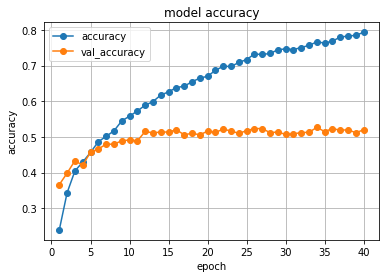

In [ ]:
# グラフ描画
# Accuracy
history = model.fit(train_images, train_labels, epochs=epochs,validation_split=0.2)
plt.plot(range(1, epochs+1), history.history['accuracy'], "-o")
plt.plot(range(1, epochs+1), history.history['val_accuracy'], "-o")
plt.title('model accuracy')
plt.ylabel('accuracy')  # Y軸ラベル
plt.xlabel('epoch')  # X軸ラベル
plt.grid()
plt.legend(['accuracy', 'val_accuracy'], loc='best')
plt.show()

In [ ]:
predictions = model.predict(test_images)
print(predictions)

[[1.3675889e-18 1.6429312e-12 1.9236434e-17 ... 1.0456070e-18
  2.5205439e-14 0.0000000e+00]
 [2.8637558e-06 2.3681521e-02 1.1404276e-08 ... 4.9734122e-10
  5.1466182e-09 1.1244478e-28]
 [2.9384091e-03 8.8526122e-02 2.6881180e-04 ... 3.5921892e-03
  5.3708940e-03 5.9467403e-11]
 ...
 [2.1669628e-01 5.6744260e-03 1.1741648e-04 ... 5.9231281e-01
  1.9978618e-03 4.7049674e-13]
 [4.6852429e-06 2.4554696e-13 1.8122853e-04 ... 9.0139848e-01
  9.8296352e-02 0.0000000e+00]
 [4.7381883e-03 1.4308732e-03 2.5291048e-04 ... 8.3434522e-01
  7.6915212e-02 4.8962245e-13]]


In [ ]:
for i in range(8000):
     sub[1][i] = np.argmax(predictions[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sub.to_csv("submission_1.tsv", sep='\t', index = None, header=None)